# Initial stab at data provided by Johns Hopkins CSSE

## Goal: To demonstrate potential for:

1. Animated visualization
2. Interactive maps
3. Static plots

Animations and maps took longer than expected (6hrs).

### Next up: novel insightful rushified reanalyses

In [1]:
# import libraries and modules
from IPython.display import HTML
get_ipython().run_line_magic('matplotlib', 'notebook')
import matplotlib.pyplot as plt
from os.path import expanduser
import pandas as pd
import numpy as np
from tabulate import tabulate
import sys
import IPython.display as display
import warnings
warnings.filterwarnings('ignore')
import csv
from math import pi
import datetime
from itertools import groupby

import matplotlib as mpl
from matplotlib import animation, rc

import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

# Declare main directory
mydir = expanduser("~/GitHub/COVID-19");

In [2]:
df_confirmed = pd.read_csv(mydir + '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_confirmed['Province/State'].fillna('N/A',inplace=True)
df_confirmed['location name'] = df_confirmed['Province/State'] + ', ' + df_confirmed['Country/Region']

df_deaths = pd.read_csv(mydir + '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_deaths['Province/State'].fillna('N/A',inplace=True)
df_deaths['location name'] = df_deaths['Province/State'] + ', ' + df_deaths['Country/Region']

df_recovered = pd.read_csv(mydir + '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_recovered['Province/State'].fillna('N/A',inplace=True)
df_recovered['location name'] = df_recovered['Province/State'] + ', ' + df_recovered['Country/Region']

In [3]:
#print(list(df_confirmed))
ProvState = df_confirmed['Province/State']
#print(ProvState.tolist())
CountryRegion = df_confirmed['Country/Region']
#print('\n', CountryRegion.tolist())

In [4]:
import re

WorldCities = pd.read_csv(mydir + '/worldcities.csv')
places = ProvState.tolist()
#places = CountryRegion.tolist()

popsize = []
for place in places:
    
    size = 0
    
    p_ls = ['Taiwan', 'San Diego County', 'Humboldt County', 'Sacramento County']
    s_ls = [23545963, 3095313, 132646, 1418788]
        
    if place in p_ls:
        i = p_ls.index(place)
        size = s_ls[i]
        
    else: 
        pattern = re.compile(r'\w\,')
        if pattern.findall(place):
            place = ','.join(place.split(',')[:-1])    
    
        subdf = WorldCities[WorldCities.isin([place]).any(1)]
        size = sum(subdf['population'])
    
    popsize.append(size)
    #print(place, ' : ', size)
    
#print(len(popsize))
#print(df_confirmed.shape)

df_confirmed['population size'] = popsize

In [5]:
yi = list(df_confirmed)
#print(yi)
yi = yi[-3]


df_sub = df_confirmed.filter(['Province/State', 'population size', yi])
df_sub = df_sub.dropna()
df_sub = df_sub[df_sub['population size'] > 0]
df_sub = df_sub[df_sub[yi] > 0]

<IPython.core.display.Javascript object>


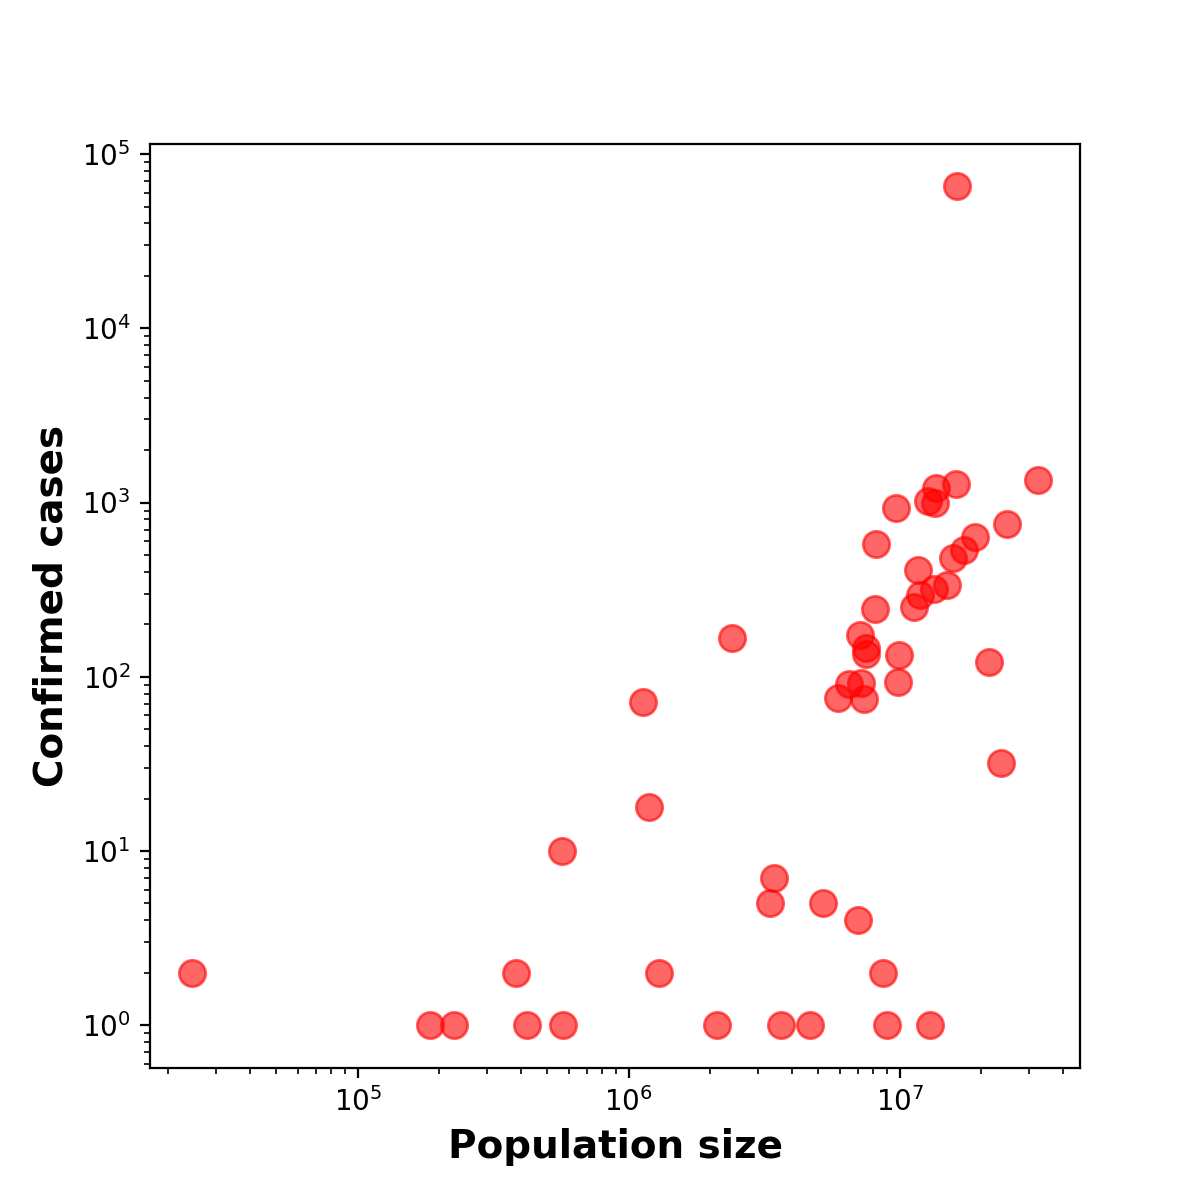

In [6]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1,1,1)

x = df_sub['population size']
y = df_sub[yi]

plt.scatter(x, y, s=90, c='r', alpha=0.6)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Confirmed cases', fontsize=14, fontweight="bold")
plt.xlabel('Population size', fontsize=14, fontweight="bold");

In [12]:
df_timeseries = df_confirmed.iloc[:,4:-2]
y1 = df_timeseries.sum()

#print(list(df_timeseries),'\n')

x = np.array(list(df_timeseries))
x1 = np.array(range(len(x)))

df_timeseries = df_recovered.iloc[:,4:-1]

#print(list(df_timeseries),'\n')


y2 = df_timeseries.sum()
x = np.array(list(df_timeseries))
x2 = np.array(range(len(x)))

df_timeseries = df_deaths.iloc[:,4:-1]

#print(list(df_timeseries),'\n')
#sys.exit()

y3 = df_timeseries.sum()
x = np.array(list(df_timeseries))
x3 = np.array(range(len(x)))

In [13]:
import folium

lats = df_confirmed['Lat']
lons = df_confirmed['Long']
cases = df_confirmed[yi]
cases = cases.tolist()

folium_map = folium.Map(location=[0, 0],
                        zoom_start=2,
                        tiles="CartoDB dark_matter")

marker = folium.CircleMarker(location=[41.8781, -87.6298])

marker.add_to(folium_map)

for i in range(len(lons)):
    op = 0.5
    folium.Circle(location=[lats[i], lons[i]], radius=(cases[i]**0.5)*10000,
      color='crimson', fill=True, fill_color='crimson',
      opacity=op).add_to(folium_map)


In [14]:
folium_map

In [15]:
%%capture
%matplotlib notebook

fig, ax = plt.subplots(figsize=(9, 3))

ax.axis([min(x1),max(x1),min(y3),max(y1)])

l = ax.fill_between([], [], color='Crimson', label='Confirmed')
j = ax.fill_between([], [], color='Steelblue', label='Recovered')
k = ax.fill_between([], [], color='0.3', label='Deaths')


plt.title("Progression since Jan 22 2019", fontweight="bold", fontsize=16)
plt.ylabel('Number of cases')
labels = list(df_timeseries)

plt.xticks(x1, labels)

plt.tick_params(axis='x', labelsize=6)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.rcParams['figure.dpi'] = 800
plt.legend(loc='upper left', frameon=False)
plt.tight_layout(pad=0.6, h_pad=None, w_pad=None, rect=None)

In [12]:
mpl.rcParams['animation.embed_limit'] = 2**64

def animate(i):
    l = ax.fill_between(x1[:i+1], y1[:i+1], color='Crimson', label='Confirmed')
    j = ax.fill_between(x2[:i+1], y2[:i+1], color='Steelblue', label='Recovered')
    k = ax.fill_between(x3[:i+1], y3[:i+1], color='0.3', label='Deaths')
    
HTML(animation.FuncAnimation(fig, animate, frames=len(x)).to_jshtml())

In [16]:
mpl.rcParams.update(mpl.rcParamsDefault)

<IPython.core.display.Javascript object>


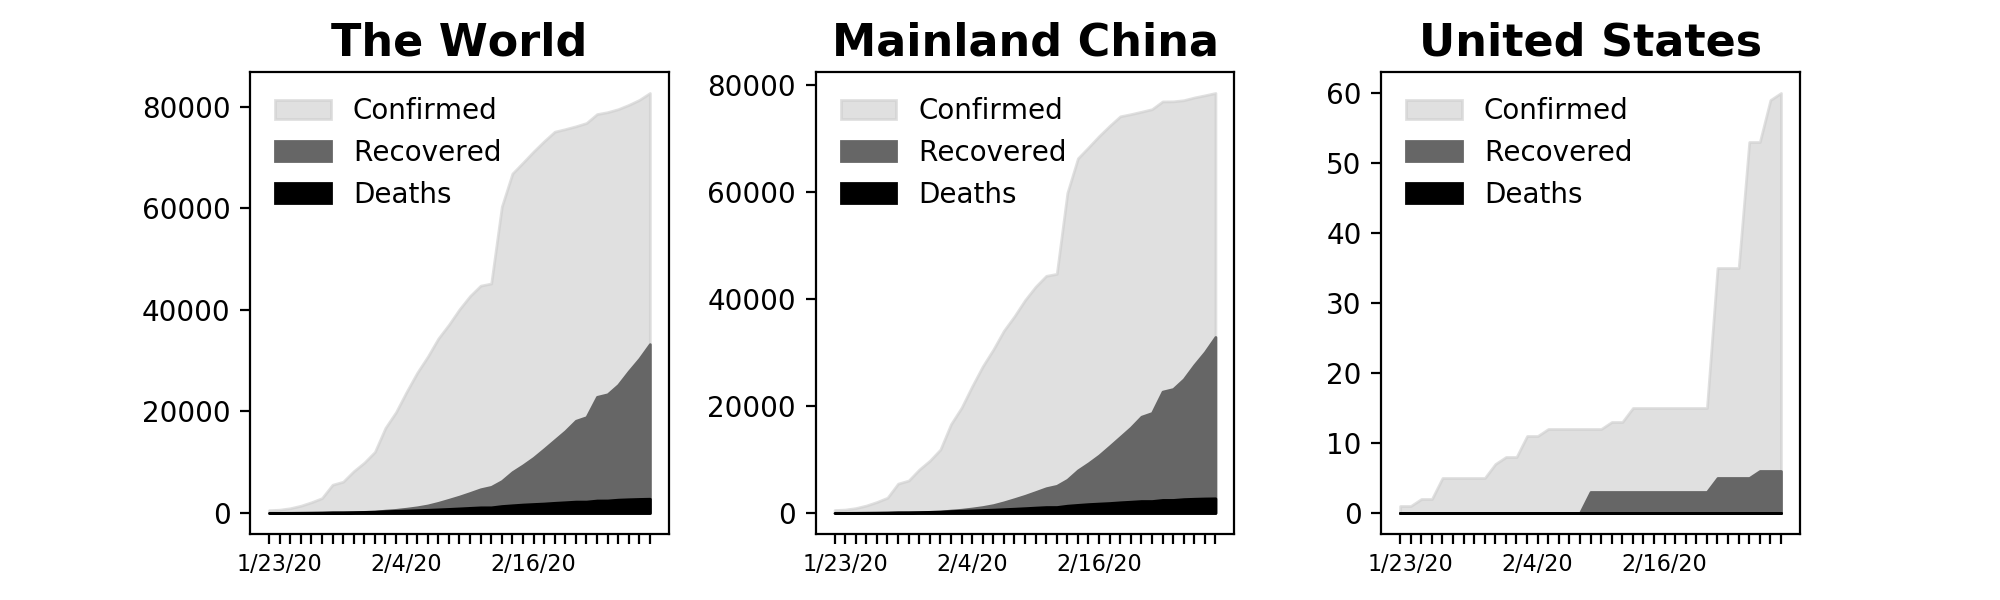

In [30]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1,3,1)

df_world_confirmed_timeseries = df_confirmed.iloc[:,4:-2]
df_world_confirmed_sum = df_world_confirmed_timeseries.sum().tolist()
dates = list(df_world_confirmed_timeseries)
plt.fill_between(x=dates, y1=df_world_confirmed_sum, color='0.8', alpha=0.6, label = 'Confirmed')

df_world_recovered_timeseries = df_recovered.iloc[:,4:-1]
df_world_recovered_sum = df_world_recovered_timeseries.sum().tolist()
plt.fill_between(x=dates, y1=df_world_recovered_sum, color='0.4', alpha=1., label = 'Recovered')

df_world_deaths_timeseries = df_deaths.iloc[:,4:-1]
df_world_deaths_sum = df_world_deaths_timeseries.sum().tolist()
plt.fill_between(x=dates, y1=df_world_deaths_sum, color='k', alpha=1., label = 'Deaths')

plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=10)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::6]))
for label in temp:
    label.set_visible(False)
    
plt.legend(loc='upper left', frameon=False)
plt.title("The World", fontweight="bold", fontsize=16)

#fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1,3,2)

df_china_confimed = df_confirmed[df_confirmed['Country/Region'] == 'Mainland China']
df_timeseries_china = df_china_confimed.iloc[:,4:-2]
df_ts_china_sum = df_timeseries_china.sum().tolist()
dates = list(df_timeseries_china)
plt.fill_between(x=dates, y1=df_ts_china_sum, color='0.8', alpha=0.6, label = 'Confirmed')

df_china_recovered = df_recovered[df_recovered['Country/Region'] == 'Mainland China']
df_timeseries_china = df_china_recovered.iloc[:,4:-1]
df_ts_china_sum = df_timeseries_china.sum().tolist()
plt.fill_between(x=dates, y1=df_ts_china_sum, color='0.4', alpha=1., label = 'Recovered')

df_china_deaths = df_deaths[df_deaths['Country/Region'] == 'Mainland China']
df_timeseries_china = df_china_deaths.iloc[:,4:-1]
df_ts_china_sum = df_timeseries_china.sum().tolist()
plt.fill_between(x=dates, y1=df_ts_china_sum, color='k', alpha=1., label = 'Deaths')

plt.tick_params(axis='x', labelsize=8)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::6]))
for label in temp:
    label.set_visible(False)
    
plt.legend(loc='upper left', frameon=False)
plt.title("Mainland China", fontweight="bold", fontsize=16)

#fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1,3,3)

df_us_confimed = df_confirmed[df_confirmed['Country/Region'] == 'US']
df_timeseries_us = df_us_confimed.iloc[:,4:-2]
df_ts_us_sum = df_timeseries_us.sum().tolist()
dates = list(df_timeseries_us)
plt.fill_between(x=dates, y1=df_ts_us_sum, color='0.8', alpha=0.6, label = 'Confirmed')

df_us_recovered = df_recovered[df_recovered['Country/Region'] == 'US']
df_timeseries_us = df_us_recovered.iloc[:,4:-1]
df_ts_us_sum = df_timeseries_us.sum().tolist()
plt.fill_between(x=dates, y1=df_ts_us_sum, color='0.4', alpha=1., label = 'Recovered')

df_us_deaths = df_deaths[df_deaths['Country/Region'] == 'US']
df_timeseries_us = df_us_deaths.iloc[:,4:-1]
df_ts_us_sum = df_timeseries_us.sum().tolist()
plt.fill_between(x=dates, y1=df_ts_us_sum, color='k', alpha=1., label = 'Deaths')

plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=10)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::6]))
for label in temp:
    label.set_visible(False)
    
plt.legend(loc='upper left', frameon=False)
plt.title("United States", fontweight="bold", fontsize=16)
plt.subplots_adjust(wspace=0.35, hspace=0.35)
plt.show()

In [23]:
print(list(dates))
print(list(df_ts_sum))

df_timeseries = df_confirmed.iloc[:,4:-2]
df_ts_sum = df_timeseries.sum().tolist()

s = pd.Series(list(dates))
s1 = pd.to_datetime(s, infer_datetime_format=True)

#print(s1)

['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20']
[17, 18, 26, 42, 56, 82, 131, 133, 171, 213, 259, 362, 426, 492, 564, 634, 719, 806, 906, 1013, 1113, 1118, 1371, 1523, 1666, 1770, 1868, 2007, 2122, 2247, 2251, 2458, 2469, 2629, 2708, 2770, 2814]
0    2020-01-22
1    2020-01-23
2    2020-01-24
3    2020-01-25
4    2020-01-26
5    2020-01-27
6    2020-01-28
7    2020-01-29
8    2020-01-30
9    2020-01-31
10   2020-02-01
11   2020-02-02
12   2020-02-03
13   2020-02-04
14   2020-02-05
15   2020-02-06
16   2020-02-07
17   2020-02-08
18   2020-02-09
19   2020-02-10
20   2020-02-11
21   2020-02-12
22   2020-02-13
23   2020-02-14
24   2020-02-15
25 

In [36]:
import pandas as pd
import plotly.graph_objects as go

# Create figure
fig = go.Figure()


df_world_confirmed_timeseries = df_confirmed.iloc[:,4:-2]
df_world_confirmed_sum = df_world_confirmed_timeseries.sum().tolist()
dates = list(df_world_confirmed_timeseries)
s = pd.Series(list(dates))
s1 = pd.to_datetime(s, infer_datetime_format=True)
fig.add_trace(go.Scatter(x=list(s1), y=list(df_world_confirmed_sum)))


df_world_recovered_timeseries = df_recovered.iloc[:,4:-2]
df_world_recovered_sum = df_world_recovered_timeseries.sum().tolist()
dates = list(df_world_recovered_timeseries)

s = pd.Series(list(dates))
s1 = pd.to_datetime(s, infer_datetime_format=True)
fig.add_trace(go.Scatter(x=list(s1), y=list(df_world_recovered_sum)))



# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="daily",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="weekly",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="monthly",
                     step="month",
                     stepmode="todate")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()